#                                                    Age Detection

## Importing all the Necessary modules.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from zipfile import ZipFile
import time
from datetime import datetime
import itertools
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [2]:
import seaborn as sns
import warnings
from tqdm.notebook import tqdm
from PIL import Image

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras import utils
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint

In [4]:
import tensorflow as tf
from keras import initializers, layers
import keras.backend as K
from keras.preprocessing.image import load_img
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input, BatchNormalization

## Importing the dataset

In [5]:
import os
for dirname, _, filenames in os.walk("C:/Users/Gaya Gopan/Downloads/UTKFace"):
    for filename in filenames:
        os.path.join(dirname, filename)

In [6]:
Data ="C:/Users/Gaya Gopan/Downloads/UTKFace"

In [7]:
image_paths = []
age_labels = []
gender_labels = []

for filename in tqdm(os.listdir(Data)):
    image_path = os.path.join(Data, filename)
    temp = filename.split('_')
    age = int(temp[0])
    gender = int(temp[1])
    image_paths.append(image_path)
    age_labels.append(age)
    gender_labels.append(gender)

  0%|          | 0/23681 [00:00<?, ?it/s]

In [8]:
df = pd.DataFrame()
df['image'], df['age'], df['gender'] = image_paths, age_labels, gender_labels
df.head()

,image,age,gender
0,C:/Users/Gaya Gopan/Downloads/UTKFace\10_0_0_2...,10,0
1,C:/Users/Gaya Gopan/Downloads/UTKFace\10_0_0_2...,10,0
2,C:/Users/Gaya Gopan/Downloads/UTKFace\10_0_0_2...,10,0
3,C:/Users/Gaya Gopan/Downloads/UTKFace\10_0_0_2...,10,0
4,C:/Users/Gaya Gopan/Downloads/UTKFace\10_0_0_2...,10,0


## Exploratory Data Analysis

In [9]:
df.shape

(23681, 3)

In [10]:
df.columns

Index(['image', 'age', 'gender'], dtype='object')

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23681 entries, 0 to 23680
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   23681 non-null  object
 1   age     23681 non-null  int64 
 2   gender  23681 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 555.2+ KB


In [12]:
df.nunique()

image     23681
age         100
gender        2
dtype: int64

In [13]:
df.duplicated().value_counts()

False    23681
Name: count, dtype: int64

In [14]:
df.duplicated().sum()

0

In [15]:
df.isna().sum()

image     0
age       0
gender    0
dtype: int64

In [16]:
gender_dict = {0:'Male', 1:'Female'}

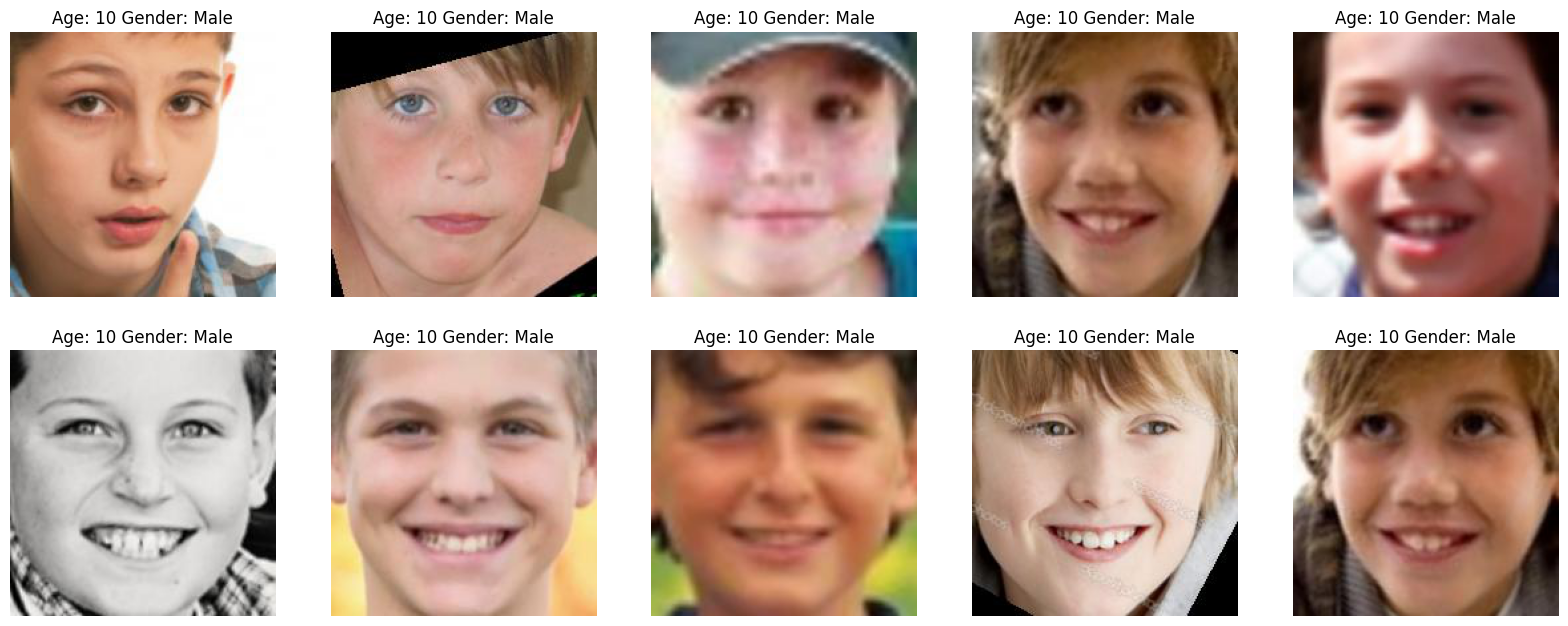

In [17]:
plt.figure(figsize=(20, 20))
files = df.iloc[0:10]

for index, file, age, gender in files.itertuples():
    plt.subplot(5, 5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(f"Age: {age} Gender: {gender_dict[gender]}")
    plt.axis('off')

C:\Users\Gaya Gopan\AppData\Local\Temp\ipykernel_15764\1462740167.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['age']);
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


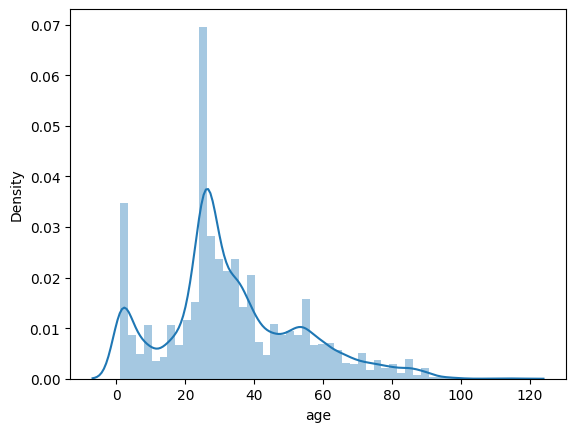

In [18]:
sns.distplot(df['age']);

C:\Users\Gaya Gopan\AppData\Local\Temp\ipykernel_15764\1193790379.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['gender']);
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


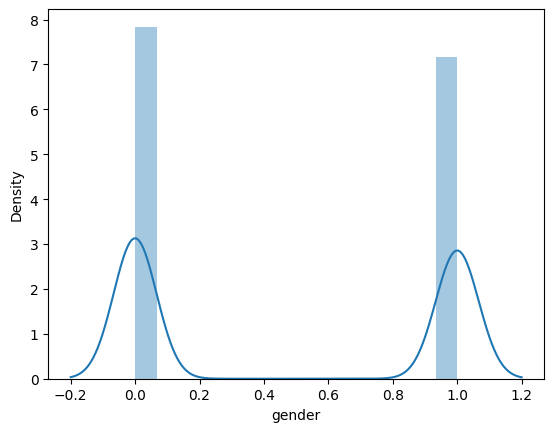

In [19]:
sns.distplot(df['gender']);

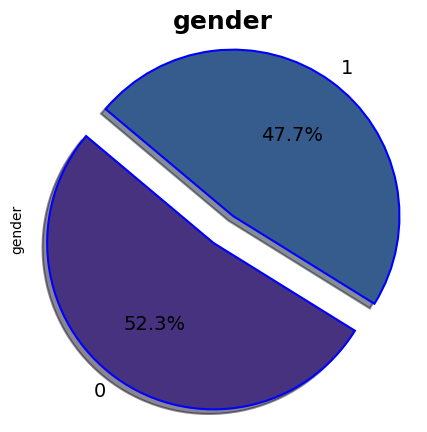

In [20]:
def plot_data(name, data):
    plt.figure(figsize=(5, 5))
    palette_color = sns.color_palette('viridis')
    explode = [0.1 for _ in range(data.nunique())]

    target_counts = df.groupby(name)[name].count()

    target_counts.plot.pie(
    colors=palette_color,
    explode=explode,
    autopct="%1.1f%%",
    shadow=True,
    startangle=140,
    textprops={'fontsize': 14},
    wedgeprops={'edgecolor': 'blue', 'linewidth': 1.5} 
    )

    plt.title(name, fontsize=18, weight='bold')
    plt.axis('equal')
    plt.show()


plot_data('gender', df['gender'])

## Feature Extraction

In [21]:
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, color_mode='grayscale')
        img = img.resize((128, 128), Image.Resampling.LANCZOS)
        img = np.array(img)
        features.append(img)
        
    features = np.array(features)
    features = features.reshape(len(features), 128, 128, 1)
    return features

In [22]:
X = extract_features(df['image'])
X = X/255.0

  0%|          | 0/23681 [00:00<?, ?it/s]

In [23]:
y_gender = np.array(df['gender'])
y_age = np.array(df['age'])

## Model Creation

In [24]:
inputs = Input((128, 128, 1))

conv_1 = layers.Conv2D(filters=256, kernel_size=9, strides=1, padding='valid', activation='relu', name='conv_1') (inputs)
batch_1 = BatchNormalization()(conv_1)
conv_2 = Conv2D(32, 5, padding = 'same', activation = 'relu', kernel_initializer = 'he_normal') (batch_1)
maxp_1 = MaxPooling2D() (conv_2)
dropout_1 = Dropout(0.25) (maxp_1)

flatten = Flatten() (dropout_1)

# fully connected layers
dense_1 = Dense(128, activation = 'relu', kernel_initializer = 'he_normal') (flatten)
dense_2 = Dense(128, activation = 'relu', kernel_initializer = 'he_normal') (flatten)

batch_2 = BatchNormalization() (dense_1)
batch_3 = BatchNormalization() (dense_2)

dropout_2 = Dropout(0.5) (batch_2)
dropout_3 = Dropout(0.5) (batch_3)

output_1 = Dense(1, activation='sigmoid', name='gender_out') (dropout_2)
output_2 = Dense(1, activation='relu', name='age_out') (dropout_3)


model = Model(inputs=[inputs], outputs=[output_1, output_2])

model.compile(loss=['binary_crossentropy', 'mae'], optimizer='adam', metrics=['accuracy', 'mae'])

In [26]:
history = model.fit(x=X, y=[y_gender, y_age], batch_size=32, epochs=5, validation_split=0.2)

Epoch 1/5
592/592 ━━━━━━━━━━━━━━━━━━━━ 8391s 14s/step - age_out_loss: 17.3316 - age_out_mae: 17.3316 - gender_out_accuracy: 0.7400 - gender_out_loss: 0.5799 - loss: 17.9115 - val_age_out_loss: 40.1136 - val_age_out_mae: 40.3172 - val_gender_out_accuracy: 0.7429 - val_gender_out_loss: 0.5551 - val_loss: 40.8747
Epoch 2/5
592/592 ━━━━━━━━━━━━━━━━━━━━ 8769s 15s/step - age_out_loss: 8.0360 - age_out_mae: 8.0360 - gender_out_accuracy: 0.8202 - gender_out_loss: 0.3948 - loss: 8.4308 - val_age_out_loss: 31.1790 - val_age_out_mae: 31.2724 - val_gender_out_accuracy: 0.7720 - val_gender_out_loss: 0.4714 - val_loss: 31.7449
Epoch 3/5
592/592 ━━━━━━━━━━━━━━━━━━━━ 9320s 16s/step - age_out_loss: 7.0762 - age_out_mae: 7.0762 - gender_out_accuracy: 0.8532 - gender_out_loss: 0.3302 - loss: 7.4065 - val_age_out_loss: 31.4128 - val_age_out_mae: 31.4903 - val_gender_out_accuracy: 0.7885 - val_gender_out_loss: 0.4607 - val_loss: 31.9527
Epoch 4/5
592/592 ━━━━━━━━━━━━━━━━━━━━ 10366s 18s/step - age_out_loss:

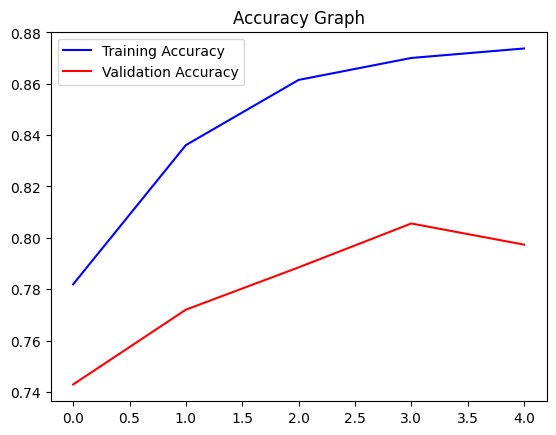

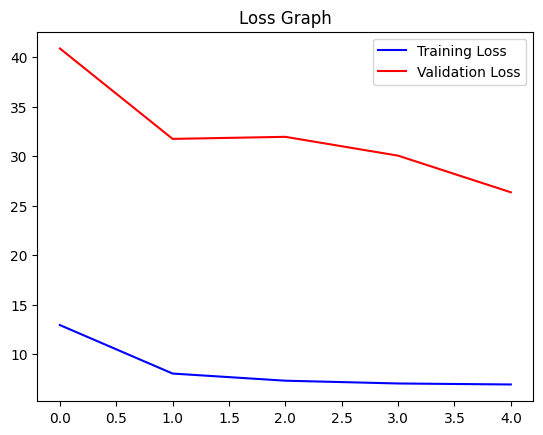

In [34]:
acc = history.history['gender_out_accuracy']
val_acc = history.history['val_gender_out_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

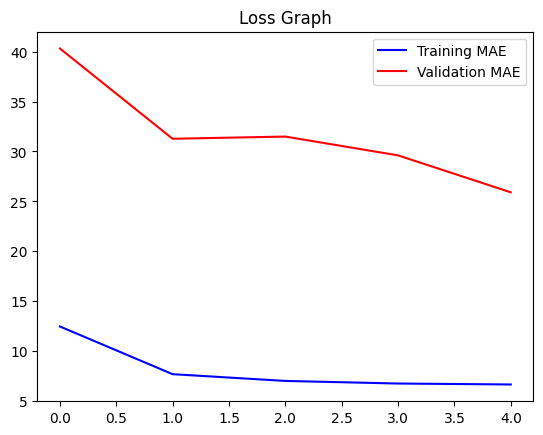

In [35]:
loss = history.history['age_out_mae']
val_loss = history.history['val_age_out_mae']
epochs = range(len(loss))

plt.plot(epochs, loss, 'b', label='Training MAE')
plt.plot(epochs, val_loss, 'r', label='Validation MAE')
plt.title('Loss Graph')
plt.legend()
plt.show()

## Prediction with Test Data

Original Age: 10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 735ms/step
Predicted Age: 14


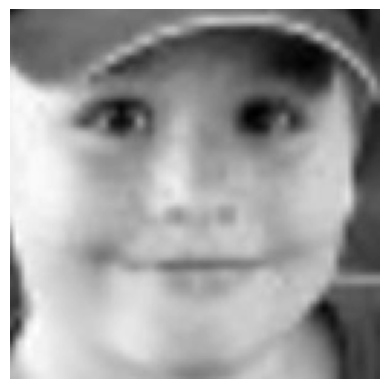

In [40]:
image_index = 2
print("Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_age = round(pred[1][0][0])
print("Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');

Original Age: 14
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 673ms/step
Predicted Age: 19


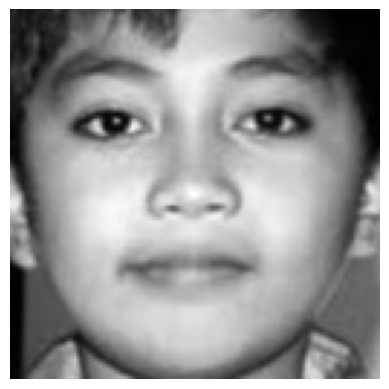

In [39]:
image_index = 500
print("Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_age = round(pred[1][0][0])
print("Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');